In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## 0. Análisis inicial

In [62]:
test = pd.read_csv('arabica_data_cleaned.csv')
test.shape

(1311, 44)

In [29]:
arabica = pd.read_csv('arabica_data_cleaned.csv')
arabica = arabica.drop(['Certification.Address', 'Certification.Contact', 'Farm.Name', 'Lot.Number', 'Mill', 'ICO.Number', 'Company', 'Region', 'Producer', 'In.Country.Partner', 
                        'Certification.Body', 'Expiration', 'Owner.1', 'Owner', 'Unnamed: 0', 'Altitude', 'Number.of.Bags', 'Bag.Weight', 'Grading.Date', 'Species', 'Harvest.Year',
                        'Total.Cup.Points'], 1)
arabica.head()

,Country.of.Origin,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Ethiopia,NaN,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,0.12,0,0.0,Green,0,m,1950.0,2200.0,2075.0
1,Ethiopia,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,0.12,0,0.0,Green,1,m,1950.0,2200.0,2075.0
2,Guatemala,Bourbon,NaN,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,0.00,0,0.0,NaN,0,m,1600.0,1800.0,1700.0
3,Ethiopia,NaN,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,0.11,0,0.0,Green,2,m,1800.0,2200.0,2000.0
4,Ethiopia,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,0.12,0,0.0,Green,2,m,1950.0,2200.0,2075.0


In [7]:
arabica.shape

(1311, 22)

In [ ]:
arabica[arabica['Total.Cup.Points'] == 0]

,Species,Country.of.Origin,Harvest.Year,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters
1310,Arabica,Honduras,2017,Caturra,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12,0,0.0,Green,2,m,1400.0,1400.0,1400.0


In [9]:
len(pd.unique(arabica['Country.of.Origin']))

37

In [64]:
len(pd.unique(test[test['Country.of.Origin']=='Guatemala']['Farm.Name']))

54

In [ ]:
arabica[arabica['Country.of.Origin']=='Guatemala']['Farm.Name'].value_counts()

finca medina                                15
conquista / morito                          11
various                                      9
el papaturro                                 9
el morito                                    8
agropecuaria quiagral                        8
la esmeralda                                 7
la esperanza                                 6
el sacramento                                6
la esperanza y anexos                        5
piamonte                                     5
la union monte verde                         5
las merceditas                               5
las delicias                                 5
nueva granada                                4
several                                      4
santo tomas pachuj                           4
finca el morito                              4
chapultepec                                  4
la castellana                                4
chiquimulja / alpha cafe / senfro            3
finca los cer

In [ ]:
arabica['Harvest.Year'].value_counts()

2012                        352
2014                        226
2013                        170
2015                        125
2016                        122
2017                         68
2013/2014                    29
2015/2016                    28
2011                         26
2017 / 2018                  19
2014/2015                    19
2009/2010                    12
2010                         10
2016 / 2017                   6
2010-2011                     6
4T/10                         4
4T/2010                       3
Mayo a Julio                  3
March 2010                    3
2009-2010                     3
08/09 crop                    2
Abril - Julio                 2
January 2011                  2
2011/2012                     2
23 July 2010                  1
May-August                    1
December 2009-March 2010      1
4T72010                       1
1t/2011                       1
TEST                          1
47/2010                       1
Spring 2

In [ ]:
arabica['Variety'].value_counts()

Caturra                  256
Bourbon                  226
Typica                   211
Other                    108
Catuai                    74
Hawaiian Kona             44
Yellow Bourbon            35
Mundo Novo                33
Catimor                   20
SL14                      17
SL28                      15
Pacas                     13
Gesha                     12
SL34                       8
Pacamara                   8
Arusha                     5
Peaberry                   5
Sumatra                    3
Mandheling                 3
Java                       2
Ethiopian Yirgacheffe      2
Blue Mountain              2
Ruiru 11                   2
Sumatra Lintong            1
Pache Comun                1
Ethiopian Heirlooms        1
Moka Peaberry              1
Marigojipe                 1
Sulawesi                   1
Name: Variety, dtype: int64

In [ ]:
arabica['Processing.Method'].value_counts()

Washed / Wet                 812
Natural / Dry                251
Semi-washed / Semi-pulped     56
Other                         26
Pulped natural / honey        14
Name: Processing.Method, dtype: int64

## 1. Feature Engineering

### Unit standarization FT  to M
Utilizado para estandarizar la medida en la que se encuentra la altitud a la que el café analizado fue cocechado. 

In [30]:
arabica['unit_of_measurement'].value_counts()

m     1129
ft     182
Name: unit_of_measurement, dtype: int64

In [11]:
def convert_to_meters(ft):
  return round(ft*0.3048,2)

In [31]:
#convert_to_meters(
arabica.loc[arabica['unit_of_measurement'] == 'ft', ['altitude_mean_meters']] = convert_to_meters(arabica[arabica['unit_of_measurement'] == 'ft']['altitude_mean_meters'])

In [32]:
arabica = arabica.drop(['unit_of_measurement'], 1)
arabica.shape

(1311, 21)

### NAN Treatment

In [33]:
## NAN Before treatment
arabica.isnull().sum()

Country.of.Origin         1
Variety                 201
Processing.Method       152
Aroma                     0
Flavor                    0
Aftertaste                0
Acidity                   0
Body                      0
Balance                   0
Uniformity                0
Clean.Cup                 0
Sweetness                 0
Cupper.Points             0
Moisture                  0
Category.One.Defects      0
Quakers                   1
Color                   216
Category.Two.Defects      0
altitude_low_meters     227
altitude_high_meters    227
altitude_mean_meters    227
dtype: int64

In [34]:
print(arabica[arabica["Country.of.Origin"].isnull()])
arabica.dropna(subset = ["Country.of.Origin"], inplace=True)

     Country.of.Origin Variety  ... altitude_high_meters  altitude_mean_meters
1197               NaN     NaN  ...                  NaN                   NaN

[1 rows x 21 columns]


In [35]:
arabica['Variety'] = arabica['Variety'].fillna('Other')

In [36]:
arabica['Processing.Method'] = arabica['Processing.Method'].fillna('Other')

In [37]:
arabica['Color'] = arabica['Color'].fillna('None')

In [38]:
arabica['Color'].value_counts()

Green           850
None            266
Bluish-Green    112
Blue-Green       82
Name: Color, dtype: int64

In [39]:
arabica["Quakers"] = arabica['Quakers'].fillna(0)

In [41]:
##Outlier treatment
arabica.loc[arabica['altitude_high_meters'] > 10000,['altitude_high_meters']]  = np.mean(arabica["altitude_high_meters"])

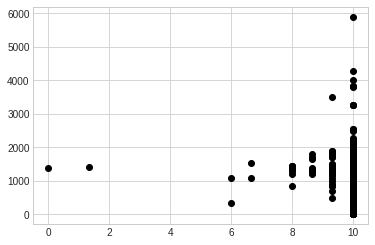

In [42]:
x = arabica["Sweetness"]
y = arabica["altitude_high_meters"]

plt.plot(x, y, 'o', color='black');

In [43]:
arabica["altitude_mean_meters"] = arabica["altitude_mean_meters"].fillna(np.mean(arabica["altitude_mean_meters"]))
arabica["altitude_high_meters"] = arabica["altitude_high_meters"].fillna(np.mean(arabica["altitude_high_meters"]))
arabica["altitude_low_meters"] = arabica["altitude_low_meters"].fillna(np.mean(arabica["altitude_low_meters"]))

In [44]:
# NAN After treatment
arabica.isnull().sum()

Country.of.Origin       0
Variety                 0
Processing.Method       0
Aroma                   0
Flavor                  0
Aftertaste              0
Acidity                 0
Body                    0
Balance                 0
Uniformity              0
Clean.Cup               0
Sweetness               0
Cupper.Points           0
Moisture                0
Category.One.Defects    0
Quakers                 0
Color                   0
Category.Two.Defects    0
altitude_low_meters     0
altitude_high_meters    0
altitude_mean_meters    0
dtype: int64

### Feature encoding

In [25]:
arabica.head()

,Country.of.Origin,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,Ethiopia,Other,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,0.12,0,0.0,Green,0,1950.0,2200.0,2075.0
1,Ethiopia,Other,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,0.12,0,0.0,Green,1,1950.0,2200.0,2075.0
2,Guatemala,Bourbon,Other,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,0.00,0,0.0,None,0,1600.0,1800.0,1700.0
3,Ethiopia,Other,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,0.11,0,0.0,Green,2,1800.0,2200.0,2000.0
4,Ethiopia,Other,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,0.12,0,0.0,Green,2,1950.0,2200.0,2075.0


In [45]:
label_encoder = LabelEncoder()
country_list = arabica["Country.of.Origin"]
arabica["Country.of.Origin"] = label_encoder.fit_transform(arabica["Country.of.Origin"])
print(arabica["Country.of.Origin"])

0        8
1        8
2        9
3        8
4        8
        ..
1306    19
1307    10
1308    21
1309     9
1310    11
Name: Country.of.Origin, Length: 1310, dtype: int64


In [46]:
variety_list = arabica["Variety"]
arabica['Variety'] = label_encoder.fit_transform(arabica["Variety"])
Processing_Method_list = arabica['Processing.Method']
arabica['Processing.Method'] = label_encoder.fit_transform(arabica['Processing.Method'])
Color_list = arabica['Color']
arabica['Color'] = label_encoder.fit_transform(arabica['Color'])

In [28]:
arabica.head()

,Country.of.Origin,Variety,Processing.Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_low_meters,altitude_high_meters,altitude_mean_meters
0,8,15,4,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,0.12,0,0.0,2,0,1950.0,2200.0,2075.0
1,8,15,4,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,0.12,0,0.0,2,1,1950.0,2200.0,2075.0
2,9,2,1,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,0.00,0,0.0,3,0,1600.0,1800.0,1700.0
3,8,15,0,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,0.11,0,0.0,2,2,1800.0,2200.0,2000.0
4,8,15,4,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,0.12,0,0.0,2,2,1950.0,2200.0,2075.0


In [48]:
arabica_train_data = arabica.copy()

## 2. Test Train Split

In [49]:
x = arabica_train_data[['Country.of.Origin', 'Variety', 'Processing.Method', 'Moisture', 'Category.One.Defects', 'Quakers', 'Color', 'Category.Two.Defects', 
                       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']]

y = arabica_train_data[arabica_train_data.columns.difference(['Country.of.Origin', 'Variety', 'Processing.Method', 'Moisture', 'Category.One.Defects', 'Quakers', 'Color', 'Category.Two.Defects', 
                       'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters'])]

In [ ]:
y.head()

,Acidity,Aftertaste,Aroma,Balance,Body,Clean.Cup,Cupper.Points,Flavor,Sweetness,Uniformity
0,8.75,8.67,8.67,8.42,8.50,10.0,8.75,8.83,10.0,10.0
1,8.58,8.50,8.75,8.42,8.42,10.0,8.58,8.67,10.0,10.0
2,8.42,8.42,8.42,8.42,8.33,10.0,9.25,8.50,10.0,10.0
3,8.42,8.42,8.17,8.25,8.50,10.0,8.67,8.58,10.0,10.0
4,8.50,8.25,8.25,8.33,8.42,10.0,8.58,8.50,10.0,10.0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=32)

In [56]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train.shape[1]

(917, 11)
(393, 11)
(917, 10)
(393, 10)


11

## 3. Neural Network 

11 neurons in layer 1 

8 neurons in layer 2 

and 10 neurons in layer 3

In [57]:
model = Sequential()

model.add(Dense(11, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(10))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 11)                132       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                70        
Total params: 316
Trainable params: 316
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
model.compile(loss='MeanSquaredError', optimizer= Adam(lr=0.01), metrics=['MSE'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [59]:
callback_a = ModelCheckpoint(filepath='my_best_model.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=10)

In [60]:
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=10, callbacks=[callback_a, callback_b])

Epoch 1/50
92/92 [==============================] - 1s 4ms/step - loss: 73197.3125 - MSE: 73197.3125 - val_loss: 801.1817 - val_MSE: 801.1817
Epoch 2/50
92/92 [==============================] - 0s 2ms/step - loss: 4008.8184 - MSE: 4008.8184 - val_loss: 160.7743 - val_MSE: 160.7743
Epoch 3/50
92/92 [==============================] - 0s 2ms/step - loss: 2044.9722 - MSE: 2044.9722 - val_loss: 68.3673 - val_MSE: 68.3673
Epoch 4/50
92/92 [==============================] - 0s 2ms/step - loss: 119.6491 - MSE: 119.6491 - val_loss: 64.9806 - val_MSE: 64.9806
Epoch 5/50
92/92 [==============================] - 0s 2ms/step - loss: 70.8454 - MSE: 70.8454 - val_loss: 60.9972 - val_MSE: 60.9972
Epoch 6/50
92/92 [==============================] - 0s 2ms/step - loss: 60.4727 - MSE: 60.4727 - val_loss: 56.9603 - val_MSE: 56.9603
Epoch 7/50
92/92 [==============================] - 0s 2ms/step - loss: 55.6730 - MSE: 55.6730 - val_loss: 52.9510 - val_MSE: 52.9510
Epoch 8/50
92/92 [========================

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=256, batch_size=10, callbacks=[callback_a, callback_b])

Epoch 1/256
92/92 [==============================] - 1s 4ms/step - loss: 1910.4908 - MSE: 1910.4908 - val_loss: 567.8591 - val_MSE: 567.8591
Epoch 2/256
92/92 [==============================] - 0s 3ms/step - loss: 352.0306 - MSE: 352.0306 - val_loss: 175.5186 - val_MSE: 175.5186
Epoch 3/256
92/92 [==============================] - 0s 2ms/step - loss: 138.7601 - MSE: 138.7601 - val_loss: 95.7975 - val_MSE: 95.7975
Epoch 4/256
92/92 [==============================] - 0s 2ms/step - loss: 86.7148 - MSE: 86.7148 - val_loss: 72.6235 - val_MSE: 72.6235
Epoch 5/256
92/92 [==============================] - 0s 2ms/step - loss: 69.5594 - MSE: 69.5594 - val_loss: 63.0470 - val_MSE: 63.0470
Epoch 6/256
92/92 [==============================] - 0s 3ms/step - loss: 62.0386 - MSE: 62.0386 - val_loss: 58.4014 - val_MSE: 58.4014
Epoch 7/256
92/92 [==============================] - 0s 2ms/step - loss: 57.9904 - MSE: 57.9904 - val_loss: 55.6014 - val_MSE: 55.6014
Epoch 8/256
92/92 [========================

### Validación de datos

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 256, 'steps': 92}


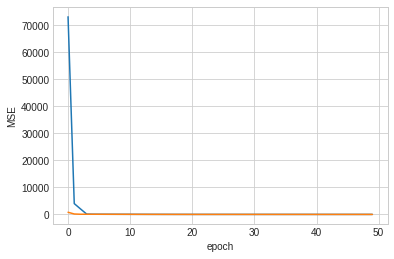

In [66]:
plt.plot(history2.history['MSE'])
plt.plot(history2.history['val_MSE'])
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

### Validation

In [ ]:
print(y_val[0:10].round())

      Acidity  Aftertaste  Aroma  ...  Flavor  Sweetness  Uniformity
872       8.0         7.0    7.0  ...     7.0       10.0        10.0
270       8.0         8.0    8.0  ...     8.0       10.0        10.0
1258      7.0         7.0    7.0  ...     7.0       10.0         9.0
1216      8.0         7.0    7.0  ...     7.0       10.0         9.0
113       8.0         8.0    8.0  ...     8.0       10.0        10.0
218       8.0         8.0    8.0  ...     8.0       10.0        10.0
749       8.0         7.0    8.0  ...     7.0       10.0        10.0
620       8.0         8.0    8.0  ...     8.0       10.0        10.0
607       8.0         7.0    8.0  ...     8.0       10.0        10.0
283       8.0         8.0    8.0  ...     7.0       10.0        10.0

[10 rows x 10 columns]


In [ ]:
prediction = model.predict(X_val)

In [ ]:
print(prediction[0:10].round())

[[ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]
 [ 8.  7.  8.  8.  8. 10.  8.  8. 10. 10.]]


<function matplotlib.pyplot.show>

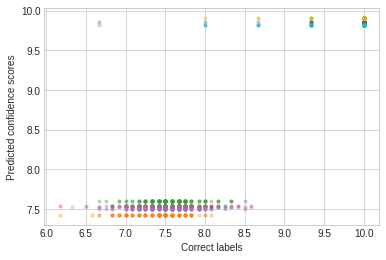

In [ ]:
plt.plot(y_val, prediction, '.', alpha = 0.3)
plt.xlabel('Correct labels')
plt.ylabel('Predicted confidence scores')
plt.show

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_val, test)

0.11790477098373875

In [ ]:
test = pd.DataFrame(prediction, dtype='float64')
test.shape

(131, 10)